## Mounting the drive:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Preparation:

In [ ]:
# Importing all the modules
import os
import csv
import pandas as pd
import numpy as np
import torch
import argparse
import pickle
import os
import logging
from tqdm import tqdm
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import pickle
import numpy as np
import torch
import matplotlib.pyplot as plt
import warnings
import torch.nn as nn
from torch.utils.data import Dataset
warnings.filterwarnings('ignore')
%matplotlib notebook
%matplotlib inline

In [ ]:
# Reading the base line file which has 347 labeled data points
df = pd.read_csv('/content/drive/MyDrive/projects/Capstone_Project/Checkpoint_5/GAN-BERT/original_data/chat_messages_intents.csv',na_values=' ')
df = df[['body', 'intent_1', 'intent_2']]
df.head(2)

,body,intent_1,intent_2
0,Hi piston! My crankshaft depends on your bore ...,Providing information,NAN
1,thank you!,NAN,NAN


In [ ]:
# Unique intents 
df['intent_1'].unique(), df['intent_2'].unique()

(array(['Providing information', 'NAN', 'Asking for information', nan],
       dtype=object), array(['NAN', 'Exploration of design parameter values',
        'Effects of design parameters on objectives',
        'Dependencies between design parameters',
        'Selected design parameter values for objective(s)',
        'Monitoring objective values', nan, 'Tradeoff between objectives',
        'Selected design parameter values for objective(s)\r\n',
        'Effects of design parameters on objectives\r\n'], dtype=object))

Takeaway: We have identified 3 unique intents for the first intent and 8 unique intents for the second intent experimental notebook. We plan to remove the NAN/ None of the above intent as it is not contributing much to the analysis.

## Data Preprocessing


#### Spell Correction

In [ ]:
!pip install pyspellchecker

     |████████████████████████████████| 2.7MB 8.4MB/s 


In [ ]:
from spellchecker import SpellChecker

spell = SpellChecker()
def correct_spellings(text):
    """custom function to check the spelling of text"""
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

for i in range(len(df['body'])):     
  text = df['body'][i]
  correct_spellings(text)

#### Chat Word Conversion

In [ ]:
import csv
import re

# Testing function for slang.txt
def translator(user_string):
    user_string = user_string.split(" ")
    j = 0
    for _str in user_string:
        # File path which consists of Abbreviations.
        fileName = "/content/drive/MyDrive/projects/Capstone_Project/Data_Checkpoint_2/slang.txt"
        # File Access mode [Read Mode]
        accessMode = "r"
        with open(fileName, accessMode) as myCSVfile:
            # Reading file as CSV with delimiter as "=", so that abbreviation are stored in row[0] and phrases in row[1]
            dataFromFile = csv.reader(myCSVfile, delimiter="=")
            # Removing Special Characters.
            _str = re.sub('[^a-zA-Z0-9-_.]', '', _str)
            for row in dataFromFile:
                # Check if selected word matches short forms[LHS] in text file.
                if _str.upper() == row[0]:
                    # If match found replace it with its Abbreviation in text file.
                    user_string[j] = row[1]
            myCSVfile.close()
        j = j + 1
    # Replacing commas with spaces for final output.
    print(' '.join(user_string))

chat_words_str = pd.read_csv('/content/drive/MyDrive/projects/Capstone_Project/Data_Checkpoint_2/slang.txt', delimiter = "\t")
chat_words_str.T.reset_index().T
chat_words_str.columns = ['Abbrevations']
chat_words_str[['Abbrevations','Chat Words Converted']] = chat_words_str.Abbrevations.str.split("=",expand=True) 

def chat_words_conversion(text):
  """custom function for chat words conversion"""
  new_text = []
  for w in text.split():
    if w.upper() in chat_words_str['Abbrevations']:
      new_text.append(chat_words_map_dict[w.upper()])
    else:
      new_text.append(w)
  return " ".join(new_text)

df["body"] = df["body"].apply(lambda text: chat_words_conversion(text))
df["body"].head()

0    Hi piston! My crankshaft depends on your bore ...
1                                           thank you!
2      How low can you go on the piston bore diameter?
3    all my fos values are in the hundreds, i suspe...
4    Hi flywheel! My crankshaft depends on your fly...
Name: body, dtype: object

#### Expanding the symbols

In [ ]:
def expsym(user_string):
    user_string = re.sub(";", " ; ", user_string)
    user_string = re.sub("\\?", " ? ", user_string)
    user_string = re.sub("=", " equals to ", user_string)
    user_string = re.sub(":", " : ", user_string)
    user_string = re.sub(">", " greater than ", user_string)
    user_string = re.sub("<", " lesser than ", user_string)
    user_string = re.sub("_", " _ ", user_string)
    user_string = re.sub("[^0-9a-zA-Z=\s:;?_-]+", " ",user_string)
    user_string = ' '.join(re.split('(\d+)', user_string))
    user_string = user_string.split(" ")
    # File path which consists of Abbreviations.
    fileName = "/content/drive/MyDrive/projects/Capstone_Project/Data_Checkpoint_2/symbols.txt"
    j = 0

    for _str in user_string:
      # File Access mode [Read Mode]
      accessMode = "r"
      with open(fileName, accessMode) as myCSVfile:
      # Reading file as CSV with delimiter as "=", so that abbreviation are stored in row[0] and phrases in row[1]
          dataFromFile = csv.reader(myCSVfile, delimiter="=")
          for row in dataFromFile:
            # Check if selected word matches short forms[LHS] in text file.
            if _str == row[0]:  
              user_string[j] = row[1]   
          myCSVfile.close()
      j = j + 1
    # Replacing commas with spaces for final output.
    return ' '.join(user_string)

In [ ]:
for i in range(len(df['body'])):
  df['body'][i] = expsym(df['body'][i])

df['body']

0       Hi piston  My crankshaft depends on your bore ...
1                                              thank you 
2       How low can you go on the piston bore diameter ? 
3       all my factorofsafety values are in the hundre...
4       Hi flywheel  My crankshaft depends on your fly...
                              ...                        
7685                                   ok no one anything
7686                                  increase it to  50 
7687                  what about thickness of flywheel ? 
7688                                  its at  12   lowest
7689                          raise it a little like  20 
Name: body, Length: 7690, dtype: object

## Dividing data set into labeled and unlabeled data parts:

In [ ]:
# Dividing dataset for two questions 
df_Q1 = df[['body', 'intent_1']]
df_Q2 = df[['body', 'intent_2']]
df_Q1.head(3), df_Q2.head(3)

(                                                body                intent_1
 0  Hi piston  My crankshaft depends on your bore ...   Providing information
 1                                         thank you                      NAN
 2  How low can you go on the piston bore diameter ?   Asking for information,
                                                 body                                intent_2
 0  Hi piston  My crankshaft depends on your bore ...                                     NAN
 1                                         thank you                                      NAN
 2  How low can you go on the piston bore diameter ?   Exploration of design parameter values)

In [ ]:
# Checking out the final labeled and unlabeled instances for the first df
total_Q1 = len(df_Q1['intent_1'])
unlabeled_instances_Q1 = df_Q1['intent_1'].isnull().sum()
labeled_instances_Q1 = total_Q1 - unlabeled_instances_Q1
print('Labeled instances in first dataframe: ', labeled_instances_Q1, ' and Unlabeled instances in first dataframe: ', unlabeled_instances_Q1)

Labeled instances in first dataframe:  347  and Unlabeled instances in first dataframe:  7343


In [ ]:
# Checking out the final labeled and unlabeled instances in the first instance
total_Q2 = len(df_Q2['intent_2'])
unlabeled_instances_Q2 = df_Q2['intent_2'].isnull().sum()
labeled_instances_Q2 = total_Q2 - unlabeled_instances_Q2
print('Labeled instances in second dataframe: ', labeled_instances_Q2, ' and Unlabeled instances in second dataframe: ', unlabeled_instances_Q2)

Labeled instances in second dataframe:  347  and Unlabeled instances in second dataframe:  7343


In [ ]:
# Dropping the NAN/None of the above intent
df_Q1.drop(index = df_Q1.index[(df_Q1['intent_1']=='NAN')], axis=0, inplace = True)
df_Q2.drop(index = df_Q2.index[(df_Q2['intent_2']=='NAN')], axis=0, inplace = True)
df_Q1['intent_1'].unique(), df_Q2['intent_2'].unique()

(array(['Providing information', 'Asking for information', nan],
       dtype=object), array(['Exploration of design parameter values',
        'Effects of design parameters on objectives',
        'Dependencies between design parameters',
        'Selected design parameter values for objective(s)',
        'Monitoring objective values', nan, 'Tradeoff between objectives',
        'Selected design parameter values for objective(s)\r\n',
        'Effects of design parameters on objectives\r\n'], dtype=object))

In [ ]:
# Checking out the final labeled and unlabeled instances for the first df
total_Q1 = len(df_Q1['intent_1'])
unlabeled_instances_Q1 = df_Q1['intent_1'].isnull().sum()
labeled_instances_Q1 = total_Q1 - unlabeled_instances_Q1
print('Labeled instances in first dataframe: ', labeled_instances_Q1, ' and Unlabeled instances in first dataframe: ', unlabeled_instances_Q1)

Labeled instances in first dataframe:  272  and Unlabeled instances in first dataframe:  7343


In [ ]:
# Checking out the final labeled and unlabeled instances in the first instance
total_Q2 = len(df_Q2['intent_2'])
unlabeled_instances_Q2 = df_Q2['intent_2'].isnull().sum()
labeled_instances_Q2 = total_Q2 - unlabeled_instances_Q2
print('Labeled instances in second dataframe: ', labeled_instances_Q2, ' and Unlabeled instances in second dataframe: ', unlabeled_instances_Q2)

Labeled instances in second dataframe:  228  and Unlabeled instances in second dataframe:  7343


In [ ]:
# Renaming columns to suitable names
df_Q1.rename(columns = {'intent_1': 'label', 'body':'full_text'}, inplace = True)
df_Q2.rename(columns = {'intent_2': 'label', 'body':'full_text'}, inplace = True)
df_Q1.head(2), df_Q2.head(2)

(                                           full_text                   label
 0  Hi piston  My crankshaft depends on your bore ...   Providing information
 2  How low can you go on the piston bore diameter ?   Asking for information,
                                            full_text                                       label
 2  How low can you go on the piston bore diameter ?       Exploration of design parameter values
 3  all my factorofsafety values are in the hundre...  Effects of design parameters on objectives)

In [ ]:
# Defining the unlabeled instances dataframe
df_unlabeled_Q1 = df_Q1[pd.isnull(df_Q1['label'])]
df_unlabeled_Q2 = df_Q2[pd.isnull(df_Q2['label'])]
df_unlabeled_Q1 = df_unlabeled_Q1['full_text']
df_unlabeled_Q2 = df_unlabeled_Q2['full_text']
df_unlabeled_Q1, df_unlabeled_Q2

(56                  we have excellent quality right now
 57      Have you broadcasted your most recent design ? 
 58                  we have excellent quality right now
 65                             looks like we re done ? 
 68                                        seems like it
                              ...                       
 7685                                 ok no one anything
 7686                                increase it to  50 
 7687                what about thickness of flywheel ? 
 7688                                its at  12   lowest
 7689                        raise it a little like  20 
 Name: full_text, Length: 7343, dtype: object,
 56                  we have excellent quality right now
 57      Have you broadcasted your most recent design ? 
 58                  we have excellent quality right now
 65                             looks like we re done ? 
 68                                        seems like it
                              ...        

In [ ]:
# Defining the labeled instances dataframe
df_labeled_Q1 = df_Q1[pd.notnull(df_Q1['label'])]
df_labeled_Q2 = df_Q2[pd.notnull(df_Q2['label'])]
df_labeled_Q1,df_labeled_Q2

(                                             full_text                   label
 0    Hi piston  My crankshaft depends on your bore ...   Providing information
 2    How low can you go on the piston bore diameter ?   Asking for information
 3    all my factorofsafety values are in the hundre...  Asking for information
 4    Hi flywheel  My crankshaft depends on your fly...   Providing information
 5                                          min of  40    Providing information
 ..                                                 ...                     ...
 701                         we are at excelelent again   Providing information
 719       flywheel changed a value and I lost  5  lbs    Providing information
 729              I decreased my weight parameter a bit   Providing information
 735    bearingoffset equals to  60   dc equals to  15    Providing information
 772  Hey  I need to know what PISTON BORE DIAMETER ...  Asking for information
 
 [272 rows x 2 columns],
             

In [ ]:
# Mapping intents to shorter abbreviations
intent = {'Asking for information': 'Asking_for_information','Providing information': 'Providing_information'}
sub_intent = {'Exploration of design parameter values' : 'Exploration_of_design_parameter_values',
        'Effects of design parameters on objectives': 'Effects_of_design_parameters_on_objectives',
        'Effects of design parameters on objectives\r\n' : 'Effects_of_design_parameters_on_objectives',
        'Dependencies between design parameters' : 'Dependencies_between_design_parameters',
        'Selected design parameter values for objective(s)': 'Selected_design_parameter_values_for_objective(s)',
        'Monitoring objective values':'Monitoring_objective_values', 'Tradeoff between objectives': 'Tradeoff_between_objectives',
        'Selected design parameter values for objective(s)\r\n': 'Selected_design_parameter_values_for_objective(s)'}      

In [ ]:
# Cleaning the labeled dataset
df_labeled_Q1["label"] = df_labeled_Q1["label"].map(intent)
df_labeled_Q2["label"] = df_labeled_Q2["label"].map(sub_intent)
df_labeled_Q1.head(2), df_labeled_Q2.head(2)

(                                           full_text                   label
 0  Hi piston  My crankshaft depends on your bore ...   Providing_information
 2  How low can you go on the piston bore diameter ?   Asking_for_information,
                                            full_text                                       label
 2  How low can you go on the piston bore diameter ?       Exploration_of_design_parameter_values
 3  all my factorofsafety values are in the hundre...  Effects_of_design_parameters_on_objectives)

In [ ]:
# Double checking the intents of labeled dataset
df_labeled_Q1.label.unique(), df_labeled_Q2.label.unique()

(array(['Providing_information', 'Asking_for_information'], dtype=object),
 array(['Exploration_of_design_parameter_values',
        'Effects_of_design_parameters_on_objectives',
        'Dependencies_between_design_parameters',
        'Selected_design_parameter_values_for_objective(s)',
        'Monitoring_objective_values', 'Tradeoff_between_objectives'],
       dtype=object))

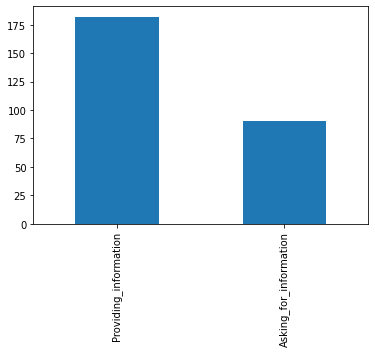

In [ ]:
pd.value_counts(df_labeled_Q1['label']).plot.bar()

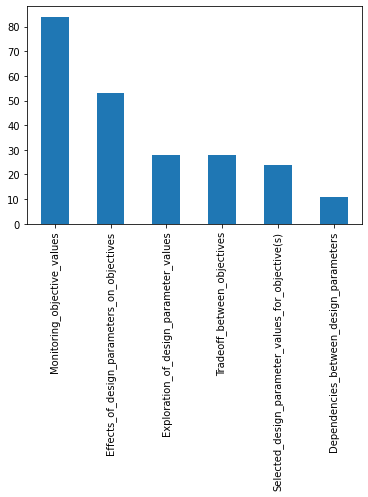

In [ ]:
pd.value_counts(df_labeled_Q2['label']).plot.bar()

In [ ]:
print('length of df_labeled_Q1: ', len(df_labeled_Q1) , ', length of df_unlabeled_Q1: ', len(df_unlabeled_Q1) , 
      'and length of df_labeled_Q2: ', len(df_labeled_Q2) , ', length of df_unlabeled_Q2: ', len(df_unlabeled_Q2))      

length of df_labeled_Q1:  272 , length of df_unlabeled_Q1:  7343 and length of df_labeled_Q2:  228 , length of df_unlabeled_Q2:  7343


In [ ]:
# Get one hot encoding of columns label
one_hot = pd.get_dummies(df_labeled_Q1['label'])
# Drop column label as it is now encoded
df_labeled_Q1 = df_labeled_Q1.drop('label',axis = 1)
# Join the encoded df
df_labeled_Q1 = df_labeled_Q1.join(one_hot)
df_labeled_Q1  

,full_text,Asking_for_information,Providing_information
0,Hi piston My crankshaft depends on your bore ...,0,1
2,How low can you go on the piston bore diameter ?,1,0
3,all my factorofsafety values are in the hundre...,1,0
4,Hi flywheel My crankshaft depends on your fly...,0,1
5,min of 40,0,1
...,...,...,...
701,we are at excelelent again,0,1
719,flywheel changed a value and I lost 5 lbs,0,1
729,I decreased my weight parameter a bit,0,1
735,bearingoffset equals to 60 dc equals to 15,0,1


In [ ]:
# Get one hot encoding of columns label
one_hot = pd.get_dummies(df_labeled_Q2['label'])
# Drop column label as it is now encoded
df_labeled_Q2 = df_labeled_Q2.drop('label',axis = 1)
# Join the encoded df
df_labeled_Q2 = df_labeled_Q2.join(one_hot)
df_labeled_Q2  

,full_text,Dependencies_between_design_parameters,Effects_of_design_parameters_on_objectives,Exploration_of_design_parameter_values,Monitoring_objective_values,Selected_design_parameter_values_for_objective(s),Tradeoff_between_objectives
2,How low can you go on the piston bore diameter ?,0,0,1,0,0,0
3,all my factorofsafety values are in the hundre...,0,1,0,0,0,0
4,Hi flywheel My crankshaft depends on your fly...,1,0,0,0,0,0
5,min of 40,0,0,0,0,1,0
6,What value works best for your simulation ?,0,0,1,0,0,0
...,...,...,...,...,...,...,...
698,we are at excellent agian,0,0,0,1,0,0
719,flywheel changed a value and I lost 5 lbs,0,1,0,0,0,0
729,I decreased my weight parameter a bit,0,1,0,0,0,0
735,bearingoffset equals to 60 dc equals to 15,1,0,0,0,0,0


In [ ]:
df_data_aug_labeled_1 = pd.read_csv('/content/drive/MyDrive/projects/Capstone_Project/Checkpoint_6/processed_data/dataaug_bert_labeled_1.csv', names = ['full_text','label'])
df_data_aug_labeled_2 = pd.read_csv('/content/drive/MyDrive/projects/Capstone_Project/Checkpoint_6/processed_data/dataaug_bert_labeled_2.csv', names = ['full_text','label'])

In [ ]:
# Get one hot encoding of columns label
one_hot = pd.get_dummies(df_data_aug_labeled_1['label'])
# Drop column label as it is now encoded
df_data_aug_labeled_1 = df_data_aug_labeled_1.drop('label',axis = 1)
# Join the encoded df
df_data_aug_labeled_1 = df_data_aug_labeled_1.join(one_hot)
df_data_aug_labeled_1  

,full_text,Asking_for_information,Providing_information
0,hi piston my crankshaft depends on your bore p...,0,1
1,how great low that can let you go on the pisto...,1,0
2,all my cash factorofsafety values are in the e...,1,0
3,o hi flywheel my crankshaft depends on your fl...,0,1
4,min of episode 40,0,1
...,...,...,...
267,we are at his excelelent port again,0,1
268,flywheel changed a value and by i had lost 5 l...,0,1
269,i greatly decreased my weight parameter of a bit,0,1
270,bearingoffset equals to only 60 so dc equals u...,0,1


In [ ]:
# Get one hot encoding of columns label
one_hot = pd.get_dummies(df_data_aug_labeled_2['label'])
# Drop column label as it is now encoded
df_data_aug_labeled_2 = df_data_aug_labeled_2.drop('label',axis = 1)
# Join the encoded df
df_data_aug_labeled_2 = df_data_aug_labeled_2.join(one_hot)
df_data_aug_labeled_2  

,full_text,Dependencies_between_design_parameters,Effects_of_design_parameters_on_objectives,Exploration_of_design_parameter_values,Monitoring_objective_values,Selected_design_parameter_values_for_objective(s),Tradeoff_between_objectives
0,how low can pitch you go off on the piston bor...,0,0,1,0,0,0
1,all my factorofsafety values tested are in abo...,0,1,0,0,0,0
2,1 hi flywheel shaft my crankshaft design depen...,1,0,0,0,0,0
3,min as of 40,0,0,0,0,1,0
4,what value works that best if for your simulat...,0,0,1,0,0,0
...,...,...,...,...,...,...,...
223,we are at this excellent agian,0,0,0,1,0,0
224,flywheel changed a value now and i once lost 5...,0,1,0,0,0,0
225,now i have decreased my weight parameter a bit,0,1,0,0,0,0
226,bearingoffset equals 1 to 0 60 pa dc equals to 15,1,0,0,0,0,0


In [ ]:
#Appending dataframes
df_labeled_Q1.append(df_data_aug_labeled_1, ignore_index=True)

,full_text,Asking_for_information,Providing_information
0,Hi piston My crankshaft depends on your bore ...,0,1
1,How low can you go on the piston bore diameter ?,1,0
2,all my factorofsafety values are in the hundre...,1,0
3,Hi flywheel My crankshaft depends on your fly...,0,1
4,min of 40,0,1
...,...,...,...
539,we are at his excelelent port again,0,1
540,flywheel changed a value and by i had lost 5 l...,0,1
541,i greatly decreased my weight parameter of a bit,0,1
542,bearingoffset equals to only 60 so dc equals u...,0,1


In [ ]:
df_labeled_Q2.append(df_data_aug_labeled_2, ignore_index=True)

,full_text,Dependencies_between_design_parameters,Effects_of_design_parameters_on_objectives,Exploration_of_design_parameter_values,Monitoring_objective_values,Selected_design_parameter_values_for_objective(s),Tradeoff_between_objectives
0,How low can you go on the piston bore diameter ?,0,0,1,0,0,0
1,all my factorofsafety values are in the hundre...,0,1,0,0,0,0
2,Hi flywheel My crankshaft depends on your fly...,1,0,0,0,0,0
3,min of 40,0,0,0,0,1,0
4,What value works best for your simulation ?,0,0,1,0,0,0
...,...,...,...,...,...,...,...
451,we are at this excellent agian,0,0,0,1,0,0
452,flywheel changed a value now and i once lost 5...,0,1,0,0,0,0
453,now i have decreased my weight parameter a bit,0,1,0,0,0,0
454,bearingoffset equals 1 to 0 60 pa dc equals to 15,1,0,0,0,0,0


In [ ]:
df_labeled_Q1.to_csv('/content/drive/MyDrive/projects/Capstone_Project/Checkpoint_6/processed_data/labeled_1.csv')
df_unlabeled_Q1.to_csv('/content/drive/MyDrive/projects/Capstone_Project/Checkpoint_6/processed_data/unlabeled_1.csv')
df_labeled_Q2.to_csv('/content/drive/MyDrive/projects/Capstone_Project/Checkpoint_6/processed_data/labeled_2.csv')
df_unlabeled_Q2.to_csv('/content/drive/MyDrive/projects/Capstone_Project/Checkpoint_6/processed_data/unlabeled_2.csv')

For first problem statement, we have 272 labeled instances ad 7343 unlabeled instances. This accounts to 3.57% of labeled material.
While in case of the second problem statement, we have 228 labeled instances ad 7343 unlabeled instances. This accounts to 3.0% of labeled material.